# Computing Recovery Metrics with `spectral_recovery`

This notebook provides a quick, interactive, example for how to start using the `spectral_recovery` package for computing recovery metrics. Specifically, this notebook will work through the steps:

1. Reading in timeseries data
2. Computing indices
3. Defining a restoration site
4. Deriving a recovery target
5. Plotting a spectral trajectory
6. Computing recovery metrics

For a more detail explanation of each step and the functions/methods they use, see the documentation page.

In [ ]:
!pip install spectral_recovery

Once the tool is installed, you can import the package:

In [1]:
import spectral_recovery as sr
import numpy as np

## Reading in Timeseries Data and Computing Indices

The set of annual composites that we'll be using in this notebook was created using the [GEE BAP tool](https://github.com/saveriofrancini/bap) and is available in the project repository's test_data directory.

In [2]:
timeseries = sr.read_timeseries(
    "test_data/annual_composites/landsat",
    band_names={1: "blue", 2: "green", 3: "red", 4: "nir", 5: "swir16", 6: "swir22"},
    array_type="dask"
)
timeseries

<xarray.DataArray (band: 6, time: 24, y: 97, x: 118)>
dask.array<transpose, shape=(6, 24, 97, 118), dtype=float32, chunksize=(1, 1, 97, 118), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 4.922e+05 4.923e+05 ... 4.934e+05 4.934e+05
  * y            (y) float64 5.968e+06 5.968e+06 ... 5.967e+06 5.967e+06
    spatial_ref  int32 0
  * time         (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2023-01-01
  * band         (band) <U2 'B' 'G' 'R' 'N' 'S1' 'S2'
Attributes:
    AREA_OR_POINT:       Area
    STATISTICS_MAXIMUM:  0.31940001249313
    STATISTICS_MEAN:     -9999
    STATISTICS_MINIMUM:  0
    STATISTICS_STDDEV:   -9999
    _FillValue:          nan
    scale_factor:        1.0
    add_offset:          0.0
    long_name:           ('blue', 'green', 'red', 'nir', 'swir1', 'swir2')

If your rasters uses 0 to represent Null data please set these values to NaN before proceeding. The `spectral_recovery` tool expects Null data to be NaN not 0. Leaving 0 values will lead to unexpected behaviour.

In [3]:
timeseries = timeseries.where(timeseries != 0.0, np.nan)

When selecting indices you should select the indices which best align with your recovery/restoration goals. For the sake of this example, we will simply compute NBR and NDVI. See the [description of the core indices] in the theoretical basis document for more information on selecting indices.

In [4]:
indices = sr.compute_indices(timeseries, indices=["NBR", "NDVI"])
indices

<xarray.DataArray (band: 2, time: 24, y: 97, x: 118)>
dask.array<concatenate, shape=(2, 24, 97, 118), dtype=float32, chunksize=(1, 1, 97, 118), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 4.922e+05 4.923e+05 ... 4.934e+05 4.934e+05
  * y            (y) float64 5.968e+06 5.968e+06 ... 5.967e+06 5.967e+06
  * time         (time) datetime64[ns] 2000-01-01 2001-01-01 ... 2023-01-01
  * band         (band) <U4 'NBR' 'NDVI'
    spatial_ref  int32 0

## Defining Restoration Site

In this example we'll look at a site of a forest fire that occured in 2005 in Northern British Columbia within the unceeded territory of Saik'uz first nation.

In [5]:
restoration_site = sr.read_restoration_polygons(
    "test_data/wildfire_516.gpkg",
    disturbance_start="2005",
    restoration_start="2006"
)
restoration_site

2005 2006


,dist_start,rest_start,geometry
0,2005,2006,"POLYGON ((493422.289 5967394.258, 493406.564 5..."


### Computing Recovery Metrics

Now that we've prepped our index timeseries data and restoration site, we can derive recovery targets:

In [36]:
hist_polygon_median = sr.targets.median_target(
    polygon=restoration_site, 
    timeseries_data=indices, 
    reference_start="2003", 
    reference_end="2004",
    scale="polygon",
)
hist_polygon_median


<xarray.DataArray (band: 2)>
dask.array<nanmedian, shape=(2,), dtype=float32, chunksize=(2,), chunktype=numpy.ndarray>
Coordinates:
    spatial_ref  int32 0
  * band         (band) <U4 'NBR' 'NDVI'

### Plotting Spectral Trajectory of Restoration Site

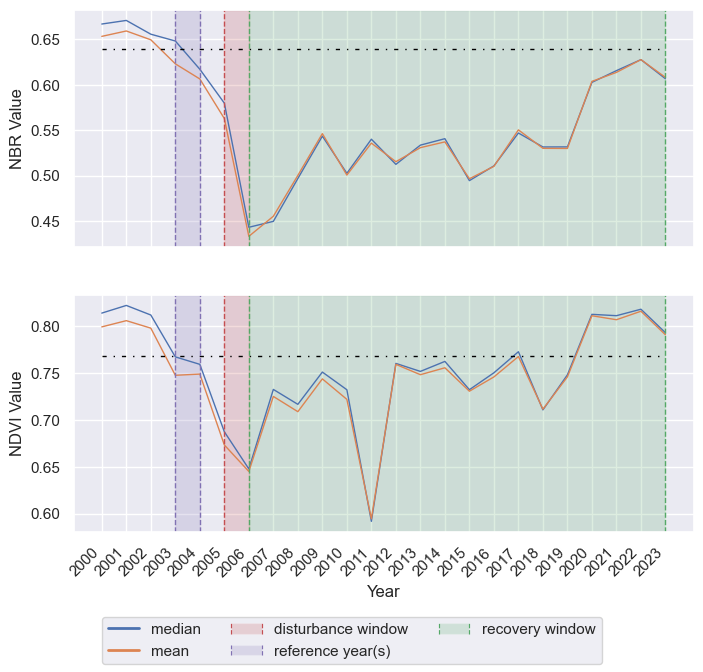

In [37]:
sr.plot_spectral_trajectory(
    timeseries_data=indices,
    restoration_polygons=restoration_site,
    recovery_target=hist_polygon_median,
    reference_start="2003", 
    reference_end="2004", 
)

## Computing Recovery Metrics

In [43]:
ra_ref = sr.compute_metrics(
    metrics=["Y2R", "dNBR", "R80P", "YrYr"],
    restoration_polygons=restoration_site,
    timeseries_data=indices,
    recovery_target=hist_polygon_median,
    timestep=4
)

AttributeError: 'list' object has no attribute 'rio'

## Viewing Recovery Metrics

In [9]:
import matplotlib.pyplot as plt

def plot_metrics(metric):
    """ Plot the three bands in a single figure. """
    fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[15, 4])
    for i in range(3):
        metric[0,i,:,:].plot(ax=axes[i])
        axes[i].set_title(f"{str(metric.metric.values[0])}: {metric['band'].values[i]}")
        axes[i].set_xlabel("X coordinate")
        if i == 0:
            axes[i].set_ylabel("Y coordinate")
        else:
            axes[i].set_ylabel("")
        plt.tight_layout()


Once you've computed your desired metrics, you can start visualization and analysis.

### Y2R

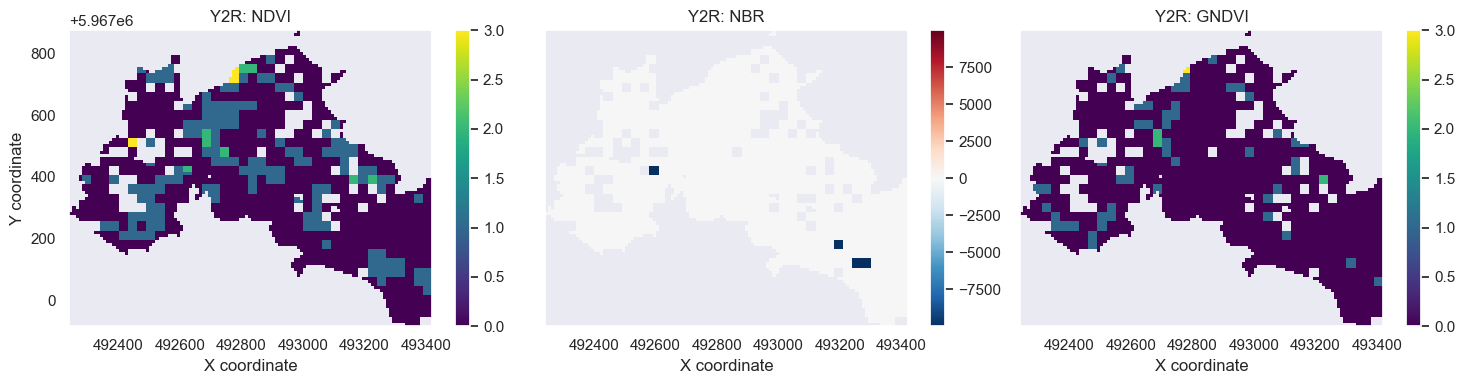

In [10]:
y2r = recovery_metrics_pixel_target.sel(metric=["Y2R"])
plot_metrics(y2r)

### R80P

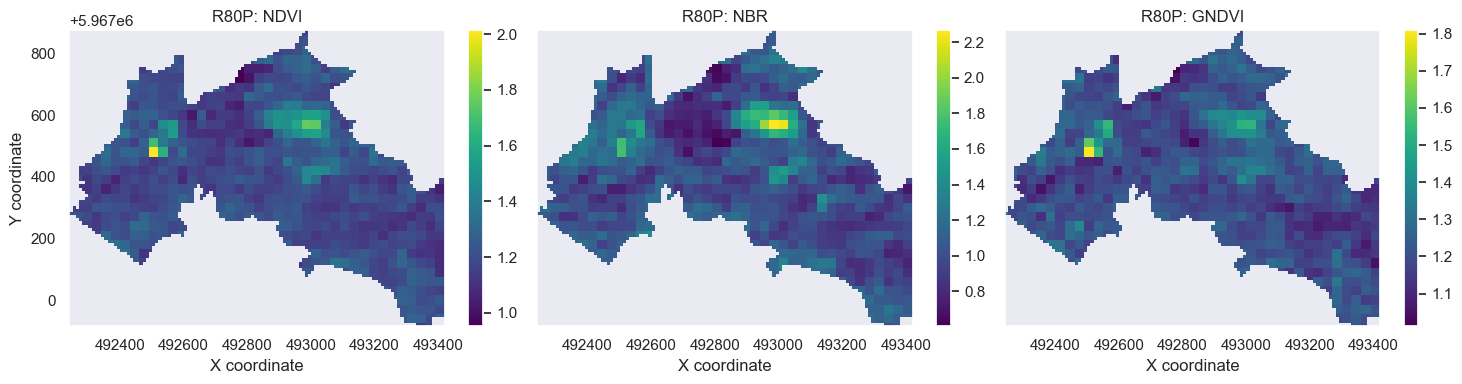

In [11]:
r80p = recovery_metrics_pixel_target.sel(metric=["R80P"])
plot_metrics(r80p)

### YrYr

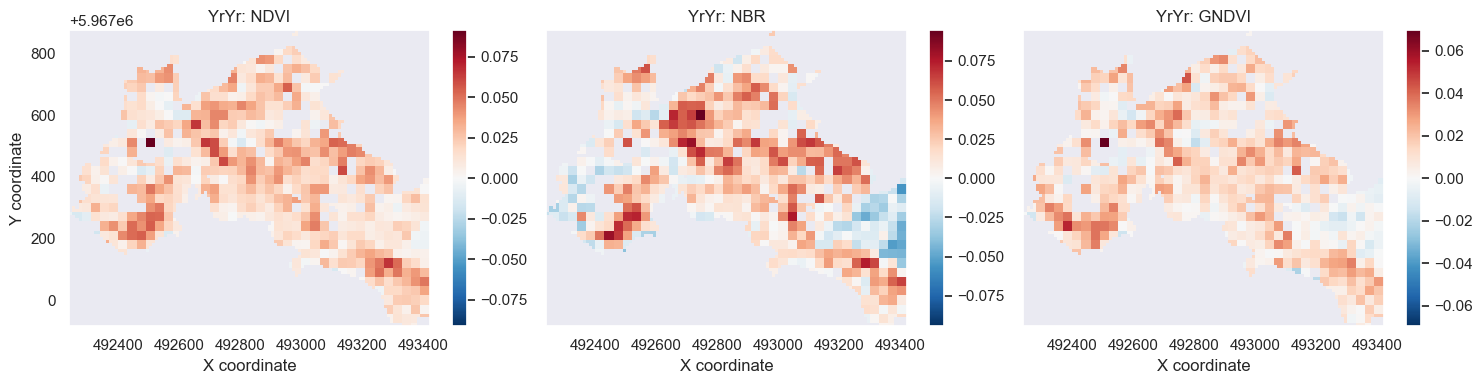

In [12]:
yryr = recovery_metrics_pixel_target.sel(metric=["YrYr"])
plot_metrics(yryr)

### dNBR

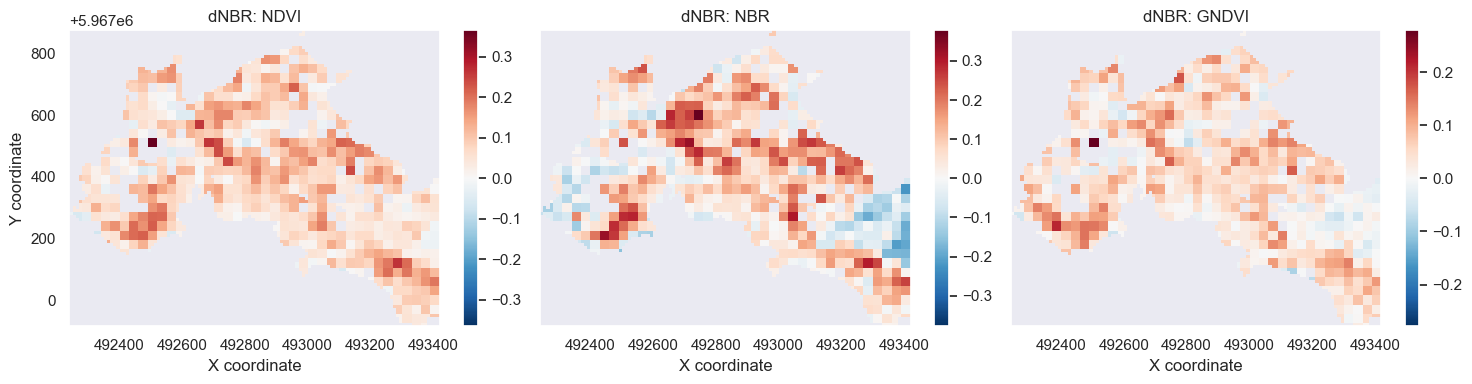

In [13]:
dNBR = recovery_metrics_pixel_target.sel(metric=["dNBR"])
plot_metrics(dNBR)

###  Writing Results

To write your metric results to raster files, the simpliest way is to use `rioxarray`'s `to_raster` function:


In [14]:
# write out y2r results to file:
y2r.sel(metric="Y2R").rio.to_raster("./y2r.tif")